<a href="https://colab.research.google.com/github/sensiml/AnalyticStudioTutorials/blob/master/SparkFun_Thing_Plus_QuickLogic_EOS_S3_Magic_Wand_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Magic Wand Demo with TensorFlow Lite

*Note: You must have a SensiML Account to use this tutorial. You can sign up for free at https://sensiml.com/plans/community-edition/*

### SensiML Python SDK

Install the SensiML Python SDK in the Google Collab environment by running the following cell. 

In [ ]:
!pip install sensiml -U


Next, we will initialize SensiML Python SDK by running the following cell. After connecting, you will be able to use the SensiML Python SDK to manage the data in your project, create queries, build and test models, and download firmware.

*Further documentation for using the SensiML Python SDK can be found at https://sensiml.com/documentation/sensiml-python-sdk/api-methods/overview.html*

In [ ]:
from sensiml import *
client = SensiML()

Next we are going to connect to our **Sparkfun Thing Plus - QuickLogic EOS S3 - Magic Wand Demo** Project. Run the following cell to connect to the project using the SensiML Python SDK. 


In [4]:
client.project = 'Sparkfun Thing Plus - QuickLogic EOS S3 - Magic Wand Demo'

### Creating the Query

The first thing we will do is create the query. The following code will create the query on the server and allow you to use it as the input to your pipeline.

In [ ]:
client.create_query(
    "Magic Spells",
    label_column="Label",
    columns=[
        "AccelerometerX",
        "AccelerometerY",
        "AccelerometerZ",
    ],
    metadata_columns=["segment_uuid"],
    segmenter="Manual",
)

The following lines of code will summarize the number of events for each class that we have in the data set.

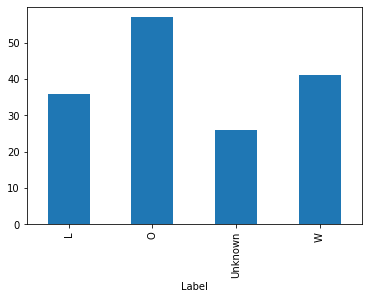

In [8]:
q = client.get_query("Magic Spells")
q.statistics_segments().groupby('Label').size().plot(kind='bar')

### Creating a pipeline 
 
Pipelines are a key component of the SensiML workflow. Pipelines store the preprocessing, feature extraction, and model building steps. When training a model, these steps are executed on the SensiML server. Once the model has been trained, the pipeline is converted to a firmware code that will run on your target embedded device. For more documentation on pipelines see the advanced model building [tutorial](https://sensiml.com/documentation/advanced-model-building/advanced-model-building.html). To create a new empty pipeline, run the cell below.

In [9]:
client.pipeline = 'TensorFlow Lite Micro'

Sandbox TensorFlow Lite Micro does not exist, creating a new sandbox.


Now we are going to add our preprocessing steps to the pipeline, for a detailed description of the features available in a pipeline see the documentation [here](https://sensiml.com/documentation/pipeline-functions/overview.html).

You can also list the functions by running ```client.list_functions(qgrid=False)``` in a code cell of the notebook.

### Adding steps to the pipeline

The pipeline for this tutorial will consist of the following steps:
 
1.   The **Input Query** which specifies what data is being fed into the model
2.   The **Segmenteation** which specifies how the data should be feed to the classifier.
3.   The **Feature Generators** which specify which features should be extracted from the raw time-series data
4.   The **Feature Transform** which specifies how to transform the features after extraction. In this case, it is to scale them to 1 byte each
5.   The **Feature Selector** which selects the best features. In this case, we are using the custom feature selector to downsample the data. 
 
 
The code in the following cell sets our initial variables, then specifies each step in the pipeline. For now, you don't need to dig into each of these steps, but just know that the end result will be a feature vector scaled to 1-byte values for each of the segments that were labeled in the Data Capture Lab. We will use these features as input to our TensorFlow model.

In [29]:
sensor_columns= list(client.project.columns())

client.pipeline.reset()

client.pipeline.set_input_query("Magic Spells") # specify the input data set to use

client.pipeline.add_segmenter("Windowing", params={"window_size": 150,
                                "delta": 25,
                                "train_delta": 25,
                                "return_segment_index": False,
                                })

client.pipeline.add_feature_generator(                 # Add Feature Generators
    [
        {'subtype_call': 'Statistical'},
        {'subtype_call': 'Shape'},
        {'subtype_call': 'Column Fusion'},
        {'subtype_call': 'Area'},
        {'subtype_call': 'Rate of Change'},
    ],
    function_defaults={'columns': sensor_columns},
)

client.pipeline.add_feature_selector([{'name':'Tree-based Selection', 'params':{"number_of_features":12}},])

client.pipeline.add_transform("Min Max Scale")     # Scale the features to 1-byte

client.pipeline.describe()

------------------------------------------------------------------------
 0.     Name: Magic Spells              		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Windowing                 		Type: segmenter                
------------------------------------------------------------------------
	group_columns: ['Label', 'segment_uuid']
	window_size: 150
	delta: 25
	train_delta: 25
	return_segment_index: False
------------------------------------------------------------------------
 2.     Name: generator_set             		Type: generatorset             
------------------------------------------------------------------------
	 0. Name: Mean                     
	 1. Name: Zero Crossings           
	 2. Name: Positive Zero Crossings  
	 3. Name: Negative Zero Crossings  
	 4. Name: Median                   
	 5. Name: Linear Regression Stats  
	

### Generating feature vectors
 
At this point the pipeline has not been executed yet, we are just assembling the steps. To run the pipeline, execute the following cell. This will execute the pipeline on SensiML Cloud and return the results as a pandas DataFrame. 
 
Once the pipeline is finished running, the results will be stored in the variable *fv_t*. A summary of the execution is stored in the *s_t* variable. 

In [30]:
fv_t, s_t = client.pipeline.execute()

Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: Magic Spells              		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Windowing                 		Type: segmenter                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: generator_set             		Type: generatorset             
------------------------------------------------------------------------
------------------------------------------------------------------------
 3.     Name: selector_set              		Type: selectorset              
------------------------------------------------------------------------
------------------------------------------------------------------------
 4.     Name: M

The output is a dataframe where each row is a feature vector representing the class.

In [31]:
fv_t.head()

,gen_0016_AccelerometerXLinearRegressionStdErr_0003,gen_0018_AccelerometerZLinearRegressionStdErr_0003,gen_0019_AccelerometerXStd,gen_0039_AccelerometerZ100Percentile,gen_0045_AccelerometerZmaximum,gen_0055_AccelerometerXVariance,gen_0057_AccelerometerZVariance,gen_0081_CCMeanCrossing,gen_0084_CCMeanCrossingOffset,gen_0100_AccelerometerXAbsArea,gen_0106_AccelerometerXAbsAreaDc,gen_0126_AccelerometerZZeroCrossingRate,Label,SegmentID,segment_uuid
0,165,92,164,252,252,109,38,85,85,161,164,85,L,0,0b6de75f-e046-4b37-b5b4-a0f306f40bd7
1,246,116,246,255,255,238,57,85,85,246,248,85,L,0,18d874a2-1675-43bb-8788-05d2d17c800d
2,171,103,171,255,255,118,46,85,85,166,165,85,L,0,1e2b2539-3ae7-43b0-b249-51076568cd77
3,201,124,201,255,255,161,68,85,85,192,196,85,L,0,20e780a7-5ca7-4d47-8daa-b09f88294400
4,212,85,212,249,249,178,32,0,0,201,209,0,L,0,26064896-d4f5-4112-9de1-2d8d7fa2dd39


Run the following cell to see the distribution of feature each across the different classes. The best features will have low variance and good class separation.

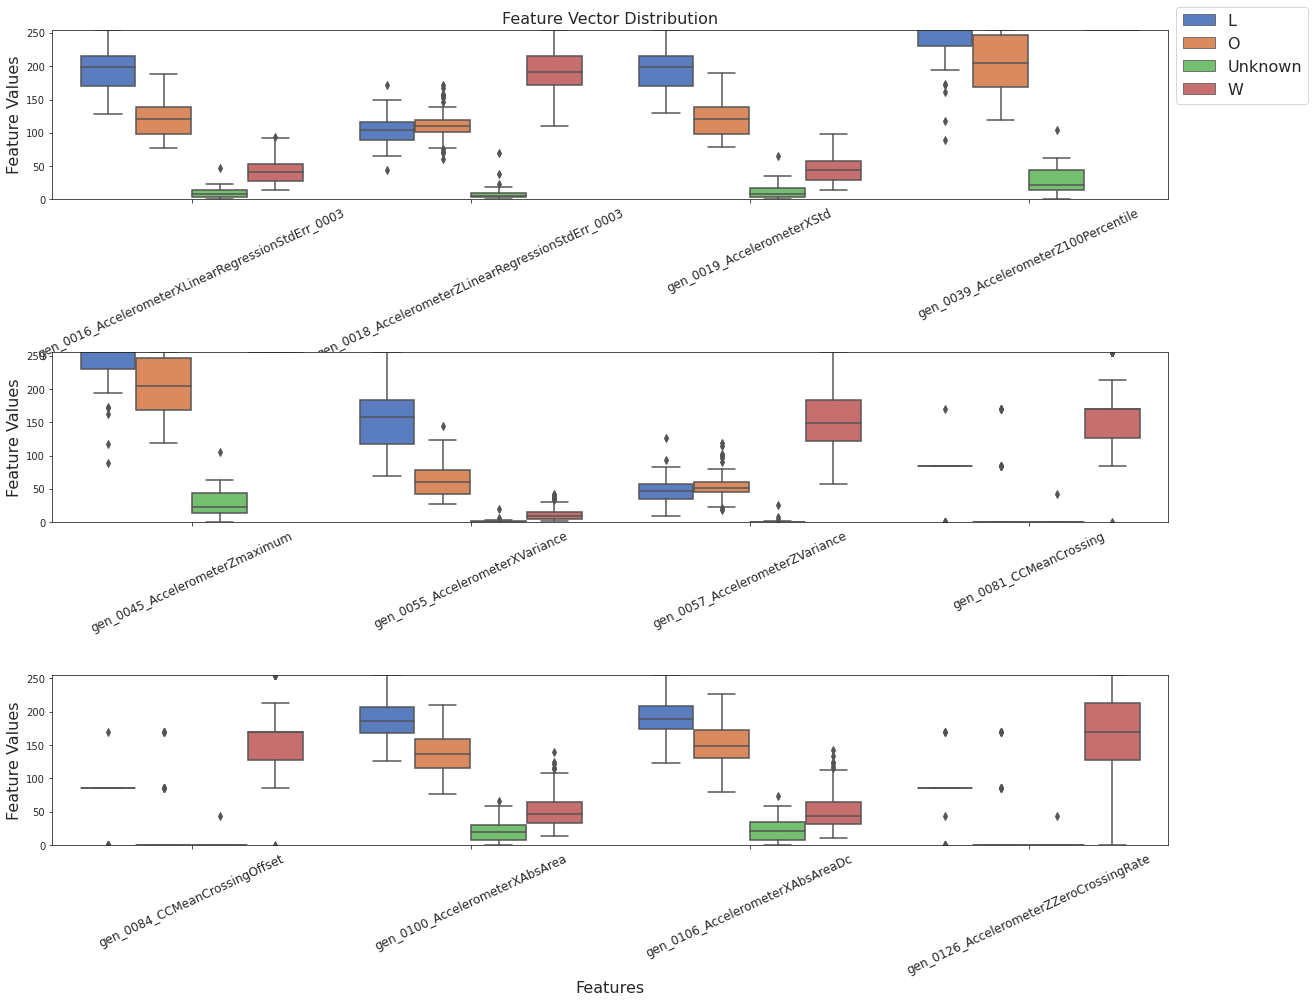

In [32]:
client.pipeline.visualize_features(fv_t)

Now we have our features for this model, we will train a TensorFlow Model in the collab environment. We will start by splitting our dataset into train and validate groups. Our test set is not included in the query and will be used later. 
 
The SensiML Python SDK has a built-in function for performing this split. You can also pass in the validation data test sizes. By default, they are set to 10% each.

In [33]:
x_train, x_test, x_validate, y_train, y_test, y_validate, class_map = \
    client.pipeline.features_to_tensor(fv_t, test=0.0, validate=.2)

-----  Summary  -----
Class Map: {'L': 0, 'O': 1, 'Unknown': 2, 'W': 3}
Train:
 total:  211
 by class: [ 31.  47.  20. 113.]
Validate:
 total:  53
 by class: [ 5. 10.  6. 32.]
Train:
 total:  0
 by class: [0. 0. 0. 0.]


### Creating a TensorFlow model
 
The Next step is to define what our TensorFlow model looks like. For this tutorial, we are going to use the TensorFlow Keras API to create the Neural Network. When you are building a model to deploy on a microcontroller, it is important to remember that all functions of TensorFlow are not suitable for a microcontroller. Additionally, only a subset of TensorFlow functions is available as part of TensorFlow Lite Micro. For a full list of available functions see the [all_ops_resolver.cc](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/all_ops_resolver.cc). 
 
For this tutorial, we will create a deep fully connected network to efficiently classify the wand gestures. Our aim is to limit the number and size of every layer in the model to only those necessary to get our desired accuracy. Often you will find that you need to make a trade-off between latency/memory usage and accuracy in order to get a model that will work well on your microcontroller.

In [34]:
from tensorflow.keras import layers
import tensorflow as tf

tf_model = tf.keras.Sequential()

tf_model.add(layers.Dense(12, activation='relu', kernel_regularizer='l1', input_shape=(x_train.shape[1],)))
tf_model.add(layers.Dropout(0.1))
tf_model.add(layers.Dense(8, activation='relu', input_shape=(x_train.shape[1],)))
tf_model.add(layers.Dropout(0.1))
tf_model.add(layers.Dense(y_train.shape[1], activation='softmax'))

# Compile the model using a standard optimizer and loss function for regression
tf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

tf_model.summary()
train_history = {'loss':[], 'val_loss':[], 'accuracy':[], 'val_accuracy':[]}

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout_6 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 104       
_________________________________________________________________
dropout_7 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 36        
Total params: 296
Trainable params: 296
Non-trainable params: 0
_________________________________________________________________


### Training the TensorFlow model
 
After defining the model graph, it is time to train the model. Training NN consists of iterating through batches of your training dataset multiple times, each time it loops through the entire training set is called an epoch. For each batch of data, the loss function is computed and the weights of the layers in the network are adjusted.  
 
The following cell will loop through the training data num_iterations of times. Each time running a specific number of epochs. After each iteration, the visualizations for the loss, accuracy, and confusion matrix will be updated for both the validation and training data sets. You can use this to see how the model is progressing. 

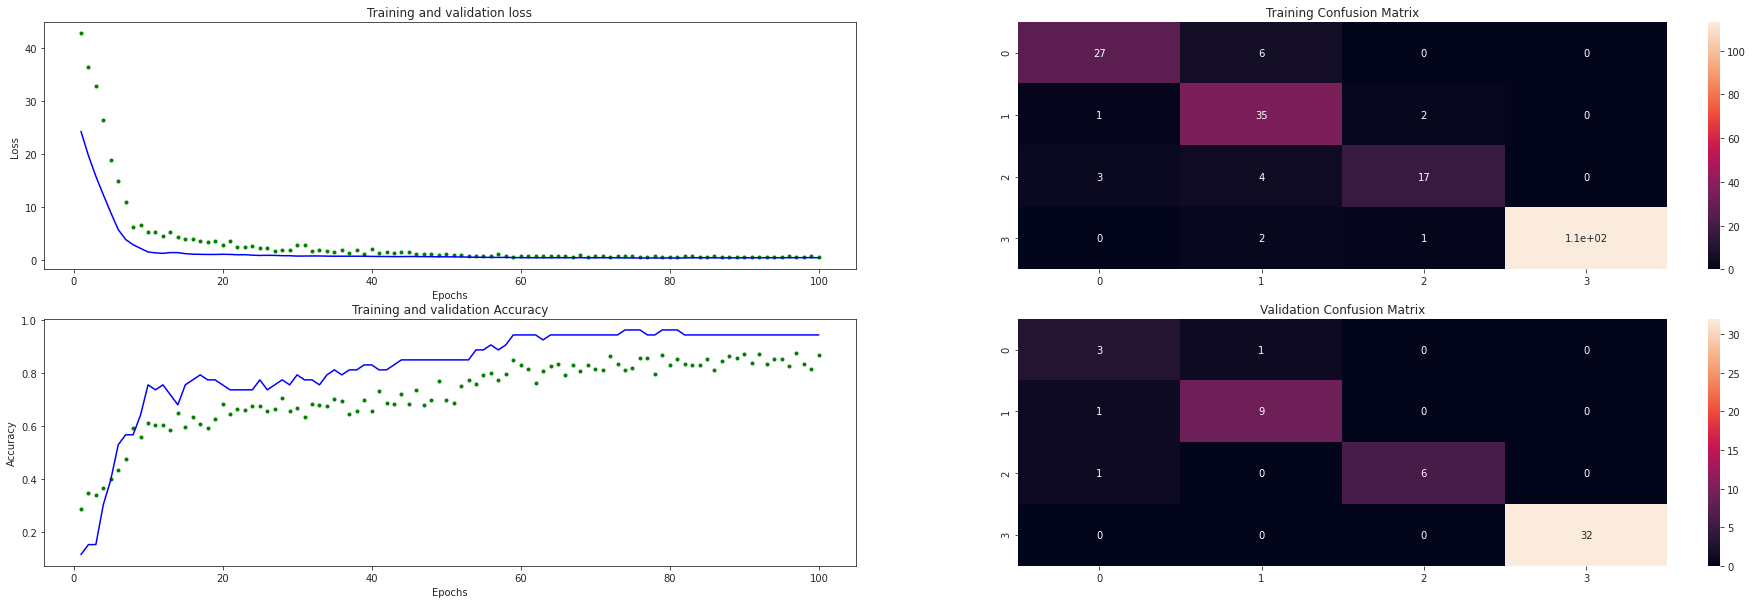

In [35]:
from IPython.display import clear_output
import sensiml.tensorflow.utils as sml_tf

num_iterations=1
epochs=100
batch_size=32


data  = tf.data.Dataset.from_tensor_slices((x_train, y_train))
shuffle_ds = data.shuffle(buffer_size=x_train.shape[0], reshuffle_each_iteration=True).batch(batch_size)

for i in range(num_iterations):
    history = tf_model.fit( shuffle_ds, epochs=epochs, batch_size=batch_size, validation_data=(x_validate, y_validate), verbose=0)

    for key in train_history:
        train_history[key].extend(history.history[key])

    clear_output()    
    sml_tf.plot_training_results(tf_model, train_history, x_train, y_train, x_validate, y_validate)


### Quantize the TensorFlow model
 
Now that you have trained a neural network with TensorFlow, we are going to use the built-in tools to quantize it. Quantization of NN allows use to reduce the model size by up to 4x by converting the network weights from 4-byte floating-point values to 1-byte uint8. This can be done without sacrificing much in terms of accuracy. The best way to perform quantization is still an active area of research. For this tutorial, we will use the built-in methods that are provided as part of TensorFlow. 
 
*   The ```representative_dataset_generator()``` function is necessary to provide statistical information about your dataset in order to quantize the model weights appropriately. 
*   The TFLiteConverter is used to convert a TensorFlow model into a tensor flow lite model. The TensorFlow Lite model is stored as a [flatbuffer](https://google.github.io/flatbuffers/) which allows us to easily store and access it on embedded systems.

In [36]:
import numpy as np
def representative_dataset_generator():
    for value in x_validate:
    # Each scalar value must be inside of a 2D array that is wrapped in a list
        yield [np.array(value, dtype=np.float32, ndmin=2)]

In [37]:
# Unquantized Model
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
tflite_model_full = converter.convert()
print("Full Model Size", len(tflite_model_full))

# Quantized Model
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.representative_dataset = representative_dataset_generator
tflite_model_quant = converter.convert()

print("Quantized Model Size", len(tflite_model_quant))

INFO:tensorflow:Assets written to: /tmp/tmplfx3lik5/assets


INFO:tensorflow:Assets written to: /tmp/tmplfx3lik5/assets


Full Model Size 3012
INFO:tensorflow:Assets written to: /tmp/tmpfbjsawtq/assets


INFO:tensorflow:Assets written to: /tmp/tmpfbjsawtq/assets


Quantized Model Size 3168


An additional benefit of quantizing the model is that TensorFlow Lite Micro is able to take advantage of specialized instructions on Cortex-M processors using the [cmsis-nn](http://www.keil.com/pack/doc/cmsis/NN/html/index.html) DSP library which gives another huge boost in performance. For more information on TensorFlow Lite for microcontrollers, you can check out the excellent [tinyml](https://www.oreilly.com/library/view/tinyml/9781492052036/) book by Pete Warden.

### Uploading the TensorFlow Lite model to SensiML Cloud 

Now that you have trained your model, its time to upload it as the final step in your pipeline. From here you will be able to test the entire pipeline against test data as well as download the firmware which can be flashed to run locally on your embedded device. To do this we will use the **Load Model TF Micro** function. We will convert the tflite model and upload it to the SensiML Cloud server. 

In [42]:
class_map_tmp = {k:v+1 for k,v in class_map.items()} #increment by 1 as 0 corresponds to unknown

client.pipeline.set_training_algorithm("Load Model TF Micro",
                                    params={"model_parameters": {
                                            'tflite': sml_tf.convert_tf_lite(tflite_model_quant)},
                                            "class_map": class_map_tmp,
                                            "estimator_type": "classification",
                                            "threshold": 0.3,
                                            "train_history":train_history,
                                            "model_json": tf_model.to_json()
                                            })

client.pipeline.set_validation_method("Recall", params={})

client.pipeline.set_classifier("TF Micro", params={})

client.pipeline.set_tvo()

results, stats = client.pipeline.execute()

Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: Magic Spells              		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Windowing                 		Type: segmenter                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: generator_set             		Type: generatorset             
------------------------------------------------------------------------
------------------------------------------------------------------------
 3.     Name: selector_set              		Type: selectorset              
------------------------------------------------------------------------
------------------------------------------------------------------------
 4.     Name: M

### Model summary
After executing the pipeline, the cloud computes a model summary as well as a confusion matrix. The model summary gives a quick overview of the model performance so we can see what the accuracy of the quantized model was across our data set.
 



In [43]:
results.summarize()

TRAINING ALGORITHM: Load Model TF Micro
VALIDATION METHOD:  Recall
CLASSIFIER:         TF Micro

AVERAGE METRICS:
                 F1_SCORE:  86.2  std: 0.00
                PRECISION:  86.2  std: 0.00
              SENSITIVITY:  86.7  std: 0.00

--------------------------------------

RECALL MODEL RESULTS : SET VALIDATION

MODEL INDEX: Fold 0
                 F1_SCORE:    train: 86.17  validation: 86.17  
              SENSITIVITY:    train: 86.72  validation: 86.72  



### Confusion matrix
 
The confusion matrix provides information not only about the accuracy but also what sort of misclassifications occurred. The confusion matrix is often one of the best ways to understand how your model is performing, as you can see which classes are difficult to distinguish between.
 
 The confusion matrix here also includes the Sensitivity and Positive Predictivity for each class along with the overall accuracy. If you raise the threshold value, you will notice that some of the classes start showing up as having UNK values. This corresponds to an unknown class and is useful for filtering out False Positives or detecting anomalous states.

In [44]:
model = results.configurations[0].models[0]
model.confusion_matrix_stats['validation']

CONFUSION MATRIX:
                   L         O   Unknown         W       UNK       UNC   Support   Sens(%)
         L      30.0       2.0       4.0       0.0       0.0       0.0      36.0      83.3
         O       7.0      45.0       4.0       1.0       0.0       0.0      57.0      78.9
   Unknown       1.0       1.0      22.0       1.0       1.0       0.0      26.0      84.6
         W       0.0       0.0       0.0     145.0       0.0       0.0     145.0     100.0

     Total        38        48        30       147         1         0       264          

PosPred(%)      78.9      93.8      73.3      98.6                        Acc(%)      91.7

 
*Finally*, we save the model knowledge pack with a name. This tells the server to persist the model. Models that you persist can be retrieved and viewed in the Analytics Studio in the future. Models that are not saved will be deleted when the pipeline is rerun. 

In [ ]:
model.knowledgepack.save("Magic_Incantation_Detector")

This completes the model training portion of the Tutorial. Open the [Analytics Studio](https://app.sensiml.cloud) to validate and download the model firmware.